In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression


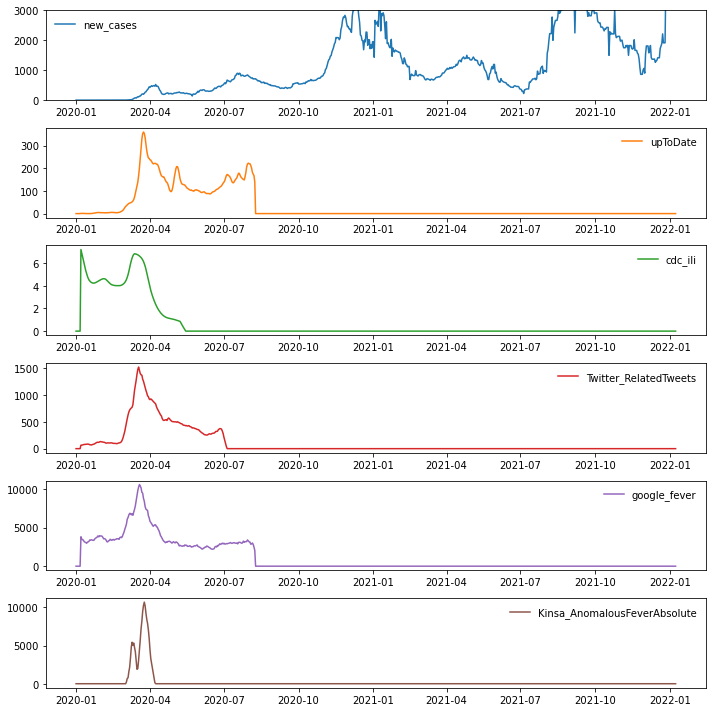

In [23]:
df = pd.read_csv('./data/covid_traces_WA.csv')
df['date'] = pd.to_datetime(df['date'])



# (a)
signals = ['new_cases', 'upToDate', 'cdc_ili',
           'Twitter_RelatedTweets', 'google_fever',
           'Kinsa_AnomalousFeverAbsolute']


fig, ax = plt.subplots(len(signals), 1)
fig.set_size_inches(10, 10)
for i, feat in enumerate(signals):
    ax[i].plot(df['date'], df[feat], label=feat, c=f'C{i}')
    ax[i].legend(frameon=False)
    
ax[0].set_ylim([0, 3000])
plt.tight_layout()
plt.show()


In [24]:
# (b)
alphas = {}
# repeat inner code over each signal
for signal in signals:
    # array to store alpha output, one entry for each day
    alpha_arr = np.zeros(len(df))
    xarr = df[signal].values
    for i in range(10, len(df)):
        # predictor is first 10 days
        before = xarr[i-10:i]
        # target is days 2-11
        after = xarr[i-9:i+1]
        lr = LinearRegression(fit_intercept=False)
        lr.fit(before.reshape(-1, 1), after)
        
        # get coefficient and store
        alpha = lr.coef_[0]
        alpha_arr[i] = alpha
    
    alphas[signal] = alpha_arr

Text(0, 0.5, 'alpha > 1')

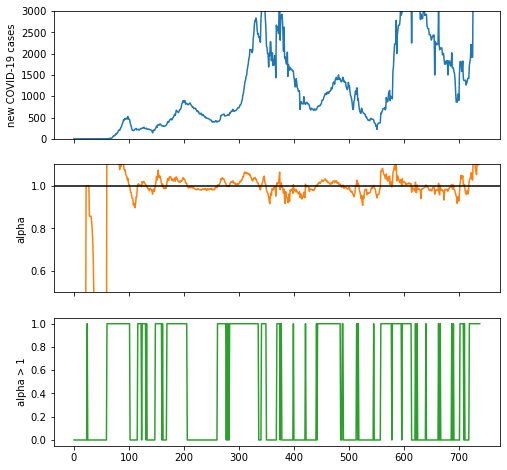

In [25]:
# (c)
fig, ax = plt.subplots(3, sharex=True)
fig.set_size_inches(8, 8)
ax[0].plot(range(len(alphas['new_cases'])), df['new_cases'], label='cases')
ax[1].plot(range(len(alphas['new_cases'])), alphas['new_cases'], label='cases', c='C1')
ax[2].plot(
    range(len(alphas['new_cases'])), (alphas['new_cases'] > 1).astype(int),
    label='cases', c='C2')

ax[1].axhline(1, c='k')
ax[0].set_ylabel('new COVID-19 cases')
ax[0].set_ylim([0, 3000])
ax[1].set_ylim([0.5, 1.1])
ax[1].set_ylabel('alpha')
ax[2].set_ylabel('alpha > 1')


In [26]:

# (d)
outbreaks = {}

# repeat the inner detection code for each signal
for signal in signals:
    # array to store detection output, one entry for each day
    out_arr = np.zeros(len(df))
    
    # we only want to mark the *start* of an outbreak, so if an outbreak is already
    # occurring, we don't mark it
    outbreak_already_active = False
    alpha_arr = alphas[signal]
    for i in range(9, len(df)):
        outbreak = 0
        # check for sustained growth over last 10 days
        if np.sum(alpha_arr[i-9:i+1] > 1) == 10:
            # if outbreak already happening, don't mark it
            if outbreak_already_active:
                outbreak = 0
            # if start of outbreak, mark it, but also mark an outbreak as active
            else:
                outbreak_already_active = True
                outbreak = 1
        # if sustained non-growth over 10 days, then end the outbreak
        elif np.sum(alpha_arr[i-9:i+1] > 1) == 0:
            outbreak_already_active = False
        out_arr[i] = outbreak    
    outbreaks[signal] = out_arr

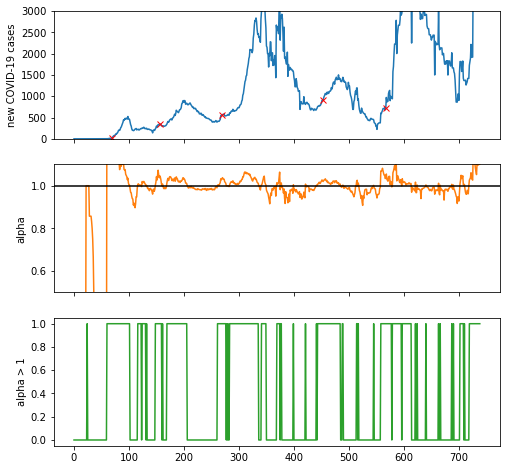

In [27]:
# (e)
outbreak_locs = {}
# for each signal, record the time indices where outbreaks start
for signal in signals:
    loc = np.where(outbreaks[signal] == 1)[0]
    outbreak_locs[signal] = loc

fig, ax = plt.subplots(3, sharex=True)
fig.set_size_inches(8, 8)
ax[0].plot(range(len(alphas['new_cases'])), df['new_cases'], label='cases')
ax[1].plot(range(len(alphas['new_cases'])), alphas['new_cases'], label='cases', c='C1')
ax[2].plot(
    range(len(alphas['new_cases'])), (alphas['new_cases'] > 1).astype(int),
    label='cases', c='C2')

ax[1].axhline(1, c='k')
ax[0].set_ylabel('new COVID-19 cases')
ax[0].set_ylim([0, 3000])
ax[1].set_ylim([0.5, 1.1])
ax[1].set_ylabel('alpha')
ax[2].set_ylabel('alpha > 1')

# add markers for outbreak locations
for t in outbreak_locs['new_cases']:
    ax[0].plot(t, df['new_cases'][t], c='r', marker='x')


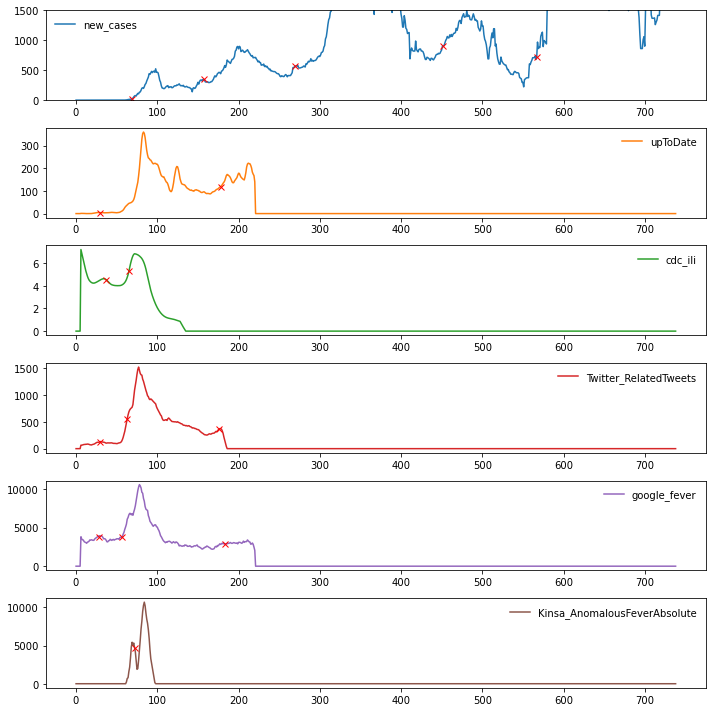

In [28]:
# (f)
fig, ax = plt.subplots(len(signals), 1)
fig.set_size_inches(10, 10)
for i, feat in enumerate(signals):
    ax[i].plot(range(len(alphas['new_cases'])), df[feat],
               label=feat, c=f'C{i}')
    
    for t in outbreak_locs[feat]:
        ax[i].plot(t, df[feat][t], c='r', marker='x')

    ax[i].legend(frameon=False)
ax[0].set_ylim([0, 1500])
plt.tight_layout()
plt.show()
